<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

## Introduction to Bootstrapping

_Authors: Kiefer Katovich (SF)_

---

### Learning Objectives

- Understand the concept of the parametric bootstrap.
- Code the parametric bootstrap by hand.
- Apply the parametric bootstrap to calculate confidence intervals for statistics.
- Understand when bootstrapping is useful.
- Practice bootstrapping.

### Lesson Guide
- [The Bootstrapping Procedure](#bootstrapping)
- [Coding the Nonparametric Bootstrap: Starcraft Data](#code-bootstrap)
- [Comparing Bootstrapped to Standard Confidence Intervals](#compare-to-classic)
- [Bootstrapping the Median](#bootstrap-median)
- [The Theory Behind the Bootstrap](#theory)
- [Independent Practice: Confidence Intervals of Correlations](#independent-practice)


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats

plt.style.use('fivethirtyeight')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

<a id='bootstrapping'></a>

## The Bootstrapping Procedure

---

Bootstrapping is a powerful resampling method that allows us to estimate our degree of uncertainty about practically any statistic. The beauty of bootstrapping is that it's done directly from the data without needing any assumptions about the distribution of our statistic!

There are many variations on the bootstrap. But, in this lesson, we'll cover only the classic **nonparametric bootstrap**. 

#### Bootstrapping the Confidence Interval of a Statistic

Say we wanted to calculate the 95% confidence interval around a statistic such as our sample mean. We could do this using the formula derived based on the central limit theorm (CLT), selecting z-scores along the normal distribution that correspond to our confidence level and multiplying them by our standard error.

The nonparametric bootstrap procedure, on the other hand, does not rely on distributional assumputions of the parameter. Below is pseudocode describing the process:

---

```
for specified number of bootstrap iterations
    create a bootstrap sample by randomly selecting observations with replacement from your sample 
        (same size as sample)
    calculate the statistic of interest on bootstrap sample

calculate lower and upper percentile bounds of bootstrap statistics according to threshold
```

---

In our case, the 95% confidence threshold would mean we'd calculate the 2.5th and 97.5th percentiles of the bootstrapped sample means.

<a id='code-bootstrap'></a>

### Coding the Nonparametric Bootstrap: Starcraft Data

---

Next, we will code the nonparametric bootstrap function and calculate the confidence interval for the mean `APM` (actions per minute) from a sample of Starcraft data. 

**Load the Starcraft data.**

In [2]:
starcraft = '../datasets/Starcraft_sample.csv'

In [4]:
star = pd.read_csv(starcraft)
print(star.shape)

(200, 20)


**Extract the `APM` vector from the data set.**

In [5]:
apm = star['APM'].values

**Plot the distribution of `APM` with a histogram.**

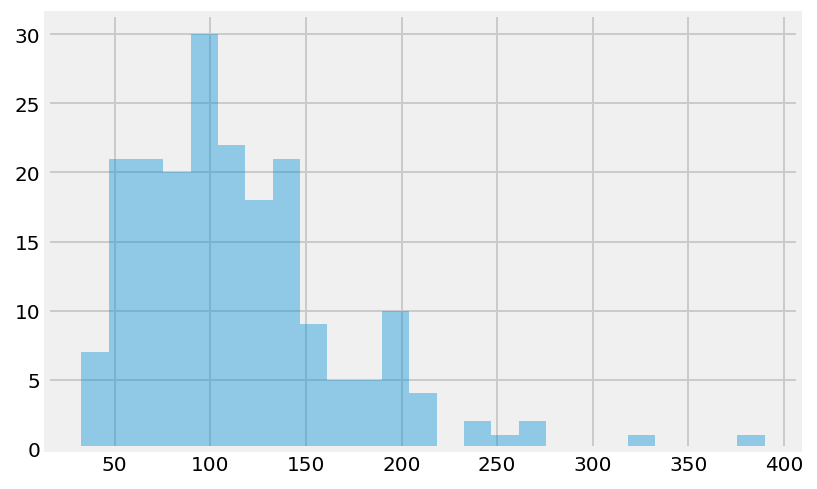

In [6]:
sns.distplot(apm, bins=25, kde=False)

**Let's write a function for the nonparametric bootstrap procedure.**

The function will take three arguments:
- The sample.
- The function to calculate the statistic of interest.
- The number of iterations.

The function should return a vector of the "bootstrapped" statistics. Refer to the pseudocode above. Remember that the random sampling must be done **with replacement** and the random sample must be the same size as the original sample.

In [7]:
def bootstrap(sample, stat_func, iters=1000):
    boots = []
    for i in range(iters):
        random_sample = np.random.choice(sample, replace=True, size=len(sample))
        stat = stat_func(random_sample)
        boots.append(stat)
    return boots

**Using our bootstrapping function with 1,000 iterations, let's calculate the 95% confidence interval for the mean `APM`.**

Remember that, for a 95% confidence interval, we will want to find the 2.5th percentile bootstrapped mean and the 97.5th percentile bootstrapped mean (corresponding to a threshold of 0.05).

The [`.scipy.stats.scoreatpercentile()`](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.scoreatpercentile.html) function is useful for finding the values at these percentiles.

In [9]:
apm_boot = bootstrap(apm, np.mean)

apm_lower = stats.scoreatpercentile(apm_boot, 2.5)
apm_upper = stats.scoreatpercentile(apm_boot, 97.5)

print(apm_lower, np.mean(apm), apm_upper)

107.49317737500002 114.323439 121.99521322499999


<a id='compare-to-classic'></a>

### Comparing Bootstrapped to Standard Confidence Intervals

---

The classic formula for calculating the confidence interval bounds for the sample mean is:

### $$ [\; \bar{x} + z_{\alpha/2}\frac{s}{\sqrt{n}},\; \bar{x} + z_{1-\alpha/2} \frac{s}{\sqrt{n}} ]$$

In our case, $\alpha = 0.05$. Filling in the appropriate z-scores according to this threshold, we have:

### $$ [\; \bar{x} -1.96 \frac{s}{\sqrt{n}},\; \bar{x} + 1.96 \frac{s}{\sqrt{n}} ]$$

**Calculate the confidence interval for the mean `APM` using the formula above and compare it to our bootstrapped confidence interval.**

In [11]:
std = np.std(apm)
sqrtn = np.sqrt(len(apm))

apm_lower = np.mean(apm) - 1.96*(std/sqrtn)
apm_upper = np.mean(apm) + 1.96*(std/sqrtn)

print(apm_lower, np.mean(apm), apm_upper)

106.90202067216315 114.323439 121.74485732783684


<a id='bootstrap-median'></a>

### Bootstrapping the Median

---

The bootstrapping procedure is not particularly useful when it comes to estimating the confidence interval surrounding the sample mean, as this mean already has helpful distributional properties. 

The bootstrap becomes much more useful when we need to calculate our uncertainty about statistics without straightforward formulas or ones with unreasonably strict assumptions. The median is one such statistic. 

**Here's the formula for finding the sample error of the median (to use when calculating the confidence interval surrounding the median):**

### $$ \text{s.e. median} = 1.2533 \cdot \text{s.e. mean} $$

This is a function of the sample error of the mean and uses a heuristic multiplier, 1.2533. Furthermore, it requires these assumptions to work:

1. $N$ is large.
2. The sample of measurements are drawn from a normally distributed population.

**Check:** What about these assumptions is impractical?

---

The second assumption is strict — many distributions are not normally distributed. Furthermore, what tangible benefit do we get from calculating the median over the mean if we know ahead of time that the population is normally distributed?

The median is much more useful when we suspect a non-normally distributed population.


**Plot the distribution of `APM` from the Starcraft data using a vertical line to indicate the median.**

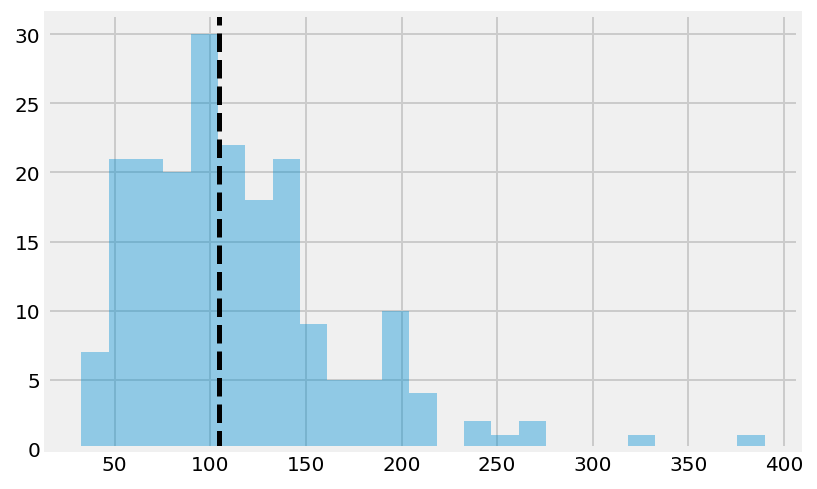

In [12]:
apm_median = np.median(apm)
ax = sns.distplot(apm, bins=25, kde=False)
ax.axvline(apm_median, lw=2.5, ls='dashed', color='black')

#### Calculate a 99% confidence interval for the median determined with the formula above.

The associated z-score magnitude is 2.576.

In [15]:
se_mean = np.std(apm)/np.sqrt(len(apm))
se_median = se_mean*1.2533

apm_med_lower = np.median(apm) - 2.576*se_median
apm_med_upper = np.median(apm) + 2.576*se_median

print(round(apm_med_lower), round(np.median(apm)), round(apm_med_upper))

92.0 104.0 117.0


**Bootstrap the 99% confidence interval for the median with 1,000 iterations.**

In [16]:
med_boot = bootstrap(apm, np.median)

med_boot_lower = stats.scoreatpercentile(med_boot, 0.5)
med_boot_upper = stats.scoreatpercentile(med_boot, 99.5)

print(med_boot_lower, np.median(apm), med_boot_upper)

96.2458575 104.3922 117.1971525


**How does bootstrapping affect the distribution?**

The bootstrapped confidence interval is wider on the right-hand side and shorter on the left. This mirrors the skew present in the data set, which we can assume is reflected in the overall population as well.  

If the skew is in fact present in the overall data set, then only the bootstrapped confidence interval is appropriate!

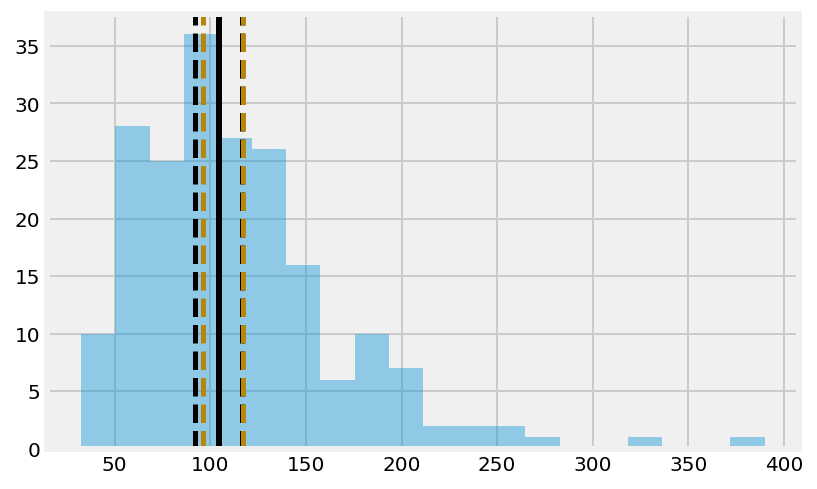

In [17]:
ax = sns.distplot(apm, bins=20, kde=False)
ax.axvline(np.median(apm), lw=3, color='black')
ax.axvline(apm_med_lower, lw=2.5, color='black', ls='dashed')
ax.axvline(apm_med_upper, lw=2.5, color='black', ls='dashed')
ax.axvline(med_boot_lower, lw=2.5, color='darkgoldenrod', ls='dashed')
ax.axvline(med_boot_upper, lw=2.5, color='darkgoldenrod', ls='dashed')

<a id='theory'></a>

### The Theory Behind the Bootstrap

---

The idea grounding the bootstrap is that inferences we draw from random samples of our sample data can in turn be applied as inferences about the overall population. This is because our random sample of the sample mirrors the fact that our sample was randomly drawn from the overall population. 

Essentially, bootstrap samples are to our original sample as our original sample is to the overall population.

With a population parameter, $\theta$, and sample statistic $\hat{\theta}$, we make an inference about the uncertainty surrounding our estimate of the population parameter.

> We infer the population, $\theta$, and the uncertainty of the inference from sample $\hat{\theta}_{s}$.

With bootstrapping, we mirror this process *to make an inference about the uncertainty surrounding our "estimate" of the sample statistic.*

> Infer the uncertainty of our sample statistic, $\hat{\theta}_{s}$, from multiple random bootstrap samples drawn from that sample.



<a id='independent-practice'></a>

### Independent Practice: Confidence Intervals of Correlations

---

Like the median, computing the confidence interval for the Pearson correlation coefficient is not straightforward without the bootstrap procedure. 

**Using the Starcraft data or another data set of your choice, calculate the correlation between two variables you are interested in and then compute the 95% and 99% confidence intervals of that correlation with the bootstrap.**

In [18]:
# Pull out `age`.
age = star['Age'].values

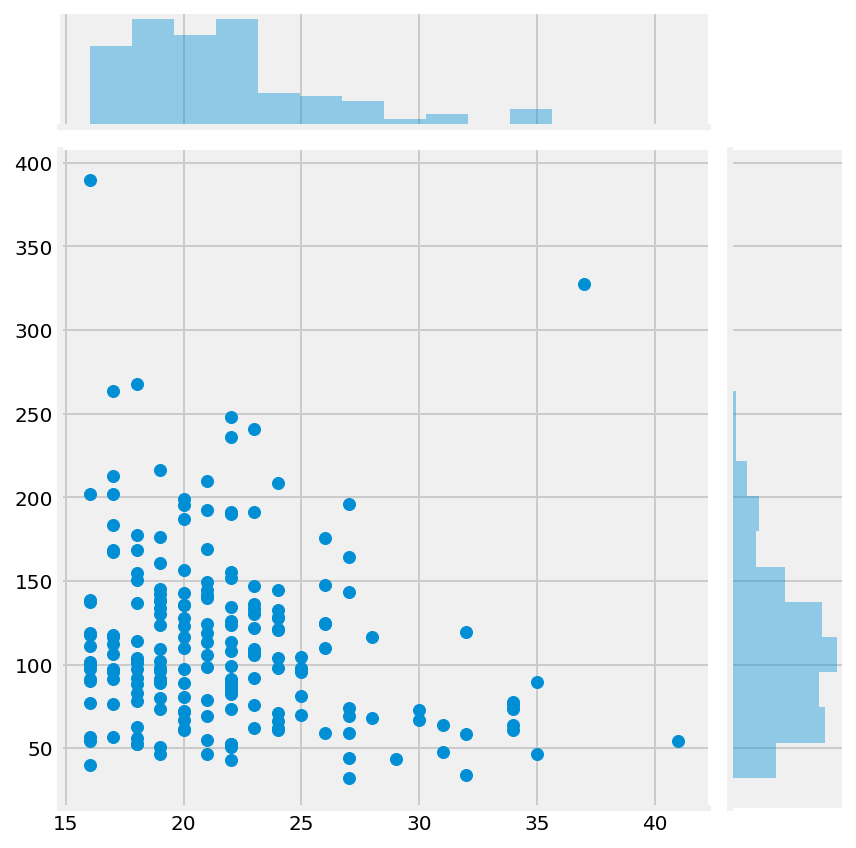

In [19]:
sns.jointplot(age, apm)

In [20]:
# Calculate the Pearson correlation coefficient between `age` and `apm`.
r = stats.pearsonr(age, apm)[0]
print(r)

-0.1778242634211112


In [21]:
# Function to bootstrap the coefficient with 1,000 iterations.
# REMEMBER: The x and y need to be paired! I bootstrap the indices
# for the different observations of `age/apm` pairs:
def bootstrap_r(x, y, iterations=1000):
    boot_r = []
    inds = range(len(x))
    for i in range(iterations):
        boot_inds = np.random.choice(inds, replace=True, size=len(inds))
        x_b = x[boot_inds]
        y_b = y[boot_inds]
        boot_r.append(stats.pearsonr(x_b, y_b)[0])
    return boot_r

In [23]:
r_boots = bootstrap_r(age, apm)

# 95%
lower = stats.scoreatpercentile(r_boots, 2.5)
upper = stats.scoreatpercentile(r_boots, 97.5)

print(lower, r, upper)

-0.3396571169204997 -0.1778242634211112 0.016924312998434395


In [24]:
# 99% confidence interval:
lower = stats.scoreatpercentile(r_boots, 0.5)
upper = stats.scoreatpercentile(r_boots, 99.5)

print(lower, r, upper)

-0.3704085586153437 -0.1778242634211112 0.08714309983629555


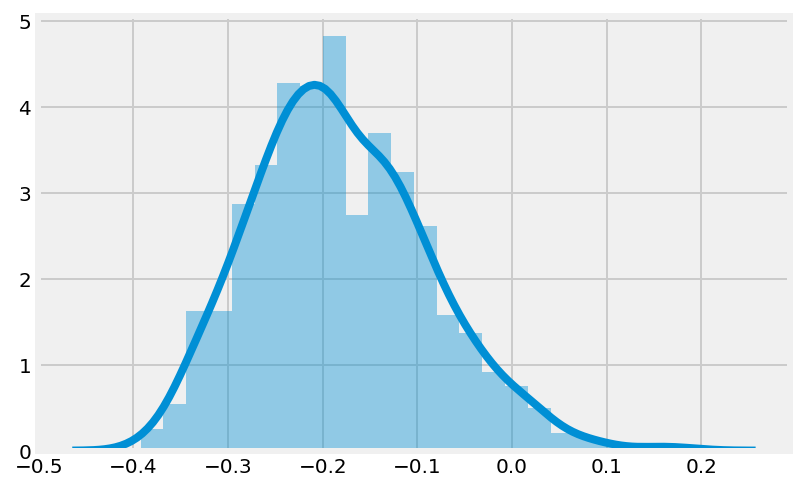

In [25]:
# The distribution of bootstrap Pearson `r` coefficients:
sns.distplot(r_boots)